In [1]:
#Imports 

import numpy as np 
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import os
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.cluster import AffinityPropagation
from sklearn import cluster

from scipy.cluster.hierarchy import dendrogram, linkage 
import scipy.cluster.hierarchy as sch

from wordcloud import WordCloud


import math
import string


path = "/Users/Aurelien/Desktop/test_jolimoi/data/"
os.chdir(path)

To open the files (I downloaded the csv files directly on Kaggle).<br>I also changed the names of the columns containing a space (easier).

In [2]:
with open ("artworks.csv",'r',encoding='utf-8') as file1:
    artworks=pd.read_csv(file1)
    
with open ("artists.csv",'r',encoding='utf-8') as file2:
    artists=pd.read_csv(file2)
    
## change columns' names containing a " "
new_cols_artists={'Artist ID':'Artist_ID','Birth Year':'Birth_Year','Death Year':'Death_Year'}
new_cols_artworks={'Artwork ID':'Artwork_ID','Artist ID':'Artist_ID',
                   'Acquisition Date':'Acquisition_Date','Object Number':'Object_Number',
                   'Diameter (cm)':'Diameter','Circumference (cm)':'Circumference','Height (cm)':'Height',
                   'Length (cm)':'Length','Width (cm)':'Width','Depth (cm)':'Depth','Weight (kg)':'Weight',
                   'Duration (s)':'Duration'}
artists.rename(columns=new_cols_artists,inplace=True)
artworks.rename(columns=new_cols_artworks,inplace=True)
n=artworks.shape[0]

In [3]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15091 entries, 0 to 15090
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Artist_ID    15091 non-null  int64  
 1   Name         15091 non-null  object 
 2   Nationality  12603 non-null  object 
 3   Gender       12019 non-null  object 
 4   Birth_Year   11237 non-null  float64
 5   Death_Year   4579 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 707.5+ KB


In [4]:
artworks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130262 entries, 0 to 130261
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Artwork_ID        130262 non-null  int64  
 1   Title             130210 non-null  object 
 2   Artist_ID         128802 non-null  object 
 3   Name              128802 non-null  object 
 4   Date              127950 non-null  object 
 5   Medium            118343 non-null  object 
 6   Dimensions        118799 non-null  object 
 7   Acquisition_Date  124799 non-null  object 
 8   Credit            127192 non-null  object 
 9   Catalogue         130262 non-null  object 
 10  Department        130262 non-null  object 
 11  Classification    130262 non-null  object 
 12  Object_Number     130262 non-null  object 
 13  Diameter          1399 non-null    float64
 14  Circumference     10 non-null      float64
 15  Height            111893 non-null  float64
 16  Length            73

In [5]:
artists.head(2)

,Artist_ID,Name,Nationality,Gender,Birth_Year,Death_Year
0,1,Robert Arneson,American,Male,1930.0,1992.0
1,2,Doroteo Arnaiz,Spanish,Male,1936.0,NaN


In [6]:
artworks.head(2)

,Artwork_ID,Title,Artist_ID,Name,Date,Medium,Dimensions,Acquisition_Date,Credit,Catalogue,...,Classification,Object_Number,Diameter,Circumference,Height,Length,Width,Depth,Weight,Duration
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,Architecture,885.1996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,Architecture,1.1995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN


Data Review.

Table "artists" :
- there are not many missing values (except for Death_Year, but it often means that the artist is still alive); for gender and nationality, the missing values can correspond to a group or an association of artists;
- the types used to describe data make sense (strings for non-numerical values and float for others).
<br>Globally, the data of "artists" is clean.

Table "artworks" :
- the table is quite large (130262 rows for 21 columns), some loops might take a significant time to end;
- there are more missing data than in "artists", and the last columns (about dimensions) are responsible for it (they could result from feature engineering on the "dimension" column, which is not really easy to handle). Moreover, we can see that the majority of objects are 2D art (Height and Width have only around 2000 missing values);
- some artworks are maybe anonymous (Artist ID and Name missing values) or unnamed (Title missing values) but it represent a small amount of them ;
- some features are very interesting : each artwork is already clustered by Department and Classification (type), also have a unique object number, giving more information than Artwork ID (I will come back on this point just below) and the technical characteristics are referenced.
<br>The data is also quite clean, but some feature engineering has to be done if we want to exploit correctly the data.

As I said before, there are already features wich allow to cluster directly the objects (Classification&Department for example, or with Artist_ID).<br>For this study, I focused mainly on Object_Number and Medium : these features connect the artists/objects by technique used, also by type and it seems to be a great way to cluster objects, artistically speaking.

About Object_Number.<br>We can find relations between objects that belong to the same "collection". For example "3.1995.1-24" corresponds to the title of a collection bought in 1995 and containing 24 objects. We can find each object with the number 3.1995.X. If we extract the 3.1995, we can map the objects belonging to the same collection.<br>There are also object numbers containing a letter, like "F" for films, I also took into account that specificity.

In [7]:
## feature engineering -> object_number


def f1(number): # object_number like "3.1995.1-24"
    L=str.split(number,".")
    if len(L)>=2:
        return(L[0]+L[1])
    # case for the numbers like FCXXX
    else:
        letters=""
        for k in L[0]:
            try :                  
                int(k)
            except ValueError:
                letters+=k
        return(letters)
    return("not assigned")
    
# modification of Object_Number column
artworks.Object_Number=artworks.Object_Number.apply(f1)


About Medium.<br>In order to find common mediums among the objects, I made some feature engineering to extract the most common words appearance (by grouping by Department and Classification).<br><br>First I tokenized the text of each medium (remove the punctuation and "common" words like the, a, of ...)

In [8]:
## feature engineering

## idée avec le tokenise

global tokenizer
tokenizer = RegexpTokenizer(r'\w+') #tokensize the text and remove the punctutation

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
alphabet="abcdefghijklmnopqrstuvwxyz"
L=[]
for i in alphabet:
    L.append(i)
stop.update(L) # we also remove the single letters (there are many in the mediums)


def f2(text):
    if type(text)==float:
        return("not assigned")
    else:
        mots = tokenizer.tokenize(text.lower())
        L=[]
        for mot in mots:
            if mot not in stop and len(mot)>=2:
                try :                   # permet d'enlever les nombres type date...
                    int(mot)
                except ValueError:
                    L.append(mot)
        return " ".join(L)
            
artworks.Medium=artworks.Medium.apply(f2)
artworks.head()

,Artwork_ID,Title,Artist_ID,Name,Date,Medium,Dimensions,Acquisition_Date,Credit,Catalogue,...,Classification,Object_Number,Diameter,Circumference,Height,Length,Width,Depth,Weight,Duration
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,ink cut pasted painted pages paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,Architecture,8851996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987,paint colored pencil print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,Architecture,11995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903,graphite pen color pencil ink gouache tracing ...,"13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,11997,NaN,NaN,34.3000,NaN,31.8000,NaN,NaN,NaN
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980,photographic reproduction colored synthetic la...,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,...,Architecture,21995,NaN,NaN,50.8000,NaN,50.8000,NaN,NaN,NaN
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903,graphite color pencil ink gouache tracing paper,"15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,21997,NaN,NaN,38.4000,NaN,19.1000,NaN,NaN,NaN


I sharpened the words' selection by removing the words having the same roots (lemmatize). For example, paint, painting, painted ... will be transformed in "paint".<br>(The process is a bit long, but there are 130k rows ...)

In [9]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    if text=="not assigned":
        return("not assigned")
    else:
        final_text = []
        for i in text.split():
            if i not in stop and len(i)>=2:
                pos = pos_tag([i.strip()])
                word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
                final_text.append(word.lower())
        return " ".join(final_text)   

# a bit long (maybe coming from my computer)
artworks.Medium=artworks.Medium.apply(lemmatize_words)

In [10]:
artworks.head()

,Artwork_ID,Title,Artist_ID,Name,Date,Medium,Dimensions,Acquisition_Date,Credit,Catalogue,...,Classification,Object_Number,Diameter,Circumference,Height,Length,Width,Depth,Weight,Duration
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,ink cut paste paint page paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,Architecture,8851996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987,paint color pencil print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,Architecture,11995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903,graphite pen color pencil ink gouache trace paper,"13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,11997,NaN,NaN,34.3000,NaN,31.8000,NaN,NaN,NaN
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980,photographic reproduction color synthetic lami...,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,...,Architecture,21995,NaN,NaN,50.8000,NaN,50.8000,NaN,NaN,NaN
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903,graphite color pencil ink gouache trace paper,"15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,21997,NaN,NaN,38.4000,NaN,19.1000,NaN,NaN,NaN


Then, by Department and Classification, I can make the list of the most common words. I chose to take the 5 most common ; I could have taken more to refine the classification but it takes too much time.<br>After, I merged the most common word lists to "artworks".<br>The next step is to intersect the medium of the row and the most common word lists, and if there is no match, I call the medium as "other".

In [11]:
def f3(text): # return the 5 (or less, if needs be) 
    L=[]
    from collections import Counter
    Counter=Counter(text.split())
    if len(Counter)<5:
        most_occur=Counter.most_common(len(Counter))
    else:
        most_occur=Counter.most_common(5) 
    for couple in most_occur :
        L.append(couple[0])
    return " ".join(L)

most_common=artworks.groupby(['Classification',"Department"])['Medium'].apply(lambda x: ' '.join(x)).reset_index()
most_common.Medium=most_common.Medium.apply(f3)
artworks=pd.merge(artworks,most_common,on=['Classification','Department'],how='outer')


Finally, the intersection.

In [12]:
def intersect(x,y): # enleve les doublons aussi
    medium=[]
    for mot in x.split():
        if mot not in medium:
            if mot in y:
                medium.append(mot)
    if medium==[]:
        return("other")
    else:
        medium.sort()
        return " ".join(medium)
    
#artworks["Medium"]=intersect(artworks.Medium_x,artworks.Medium_y)
artworks["Medium"] = artworks.Medium_x.combine(artworks.Medium_y, func=intersect)

In [13]:
del(artworks["Medium_x"])
del(artworks["Medium_y"])
artworks.head()

,Artwork_ID,Title,Artist_ID,Name,Date,Dimensions,Acquisition_Date,Credit,Catalogue,Department,...,Object_Number,Diameter,Circumference,Height,Length,Width,Depth,Weight,Duration,Medium
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,Architecture & Design,...,8851996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN,ink paper
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,Architecture & Design,...,11995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN,color pencil print
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903,"13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,Architecture & Design,...,11997,NaN,NaN,34.3000,NaN,31.8000,NaN,NaN,NaN,color ink paper pen pencil
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,Architecture & Design,...,21995,NaN,NaN,50.8000,NaN,50.8000,NaN,NaN,NaN,color
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903,"15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,Architecture & Design,...,21997,NaN,NaN,38.4000,NaN,19.1000,NaN,NaN,NaN,color ink paper pencil


First clustering : with Medium, Department, Classification (one-hot-encoding).<br>To create the one-hot-encoding rows for the Medium feature, I mapped all the words contained in the different mediums and then made the one-hot-encoding (for the other features it can be done directily thanks to pd.get_dummies).<br>I grouped by Department, Classification and Medium.

In [14]:
clustering_1=artworks.groupby(['Classification',"Department","Medium"]).size().reset_index()

In [15]:
# list containing all the words which occur in mediums
# I grouped
medium_classification=artworks.groupby(['Classification',"Department","Medium"]).size().reset_index()
n2=medium_classification.shape[0]
all_mediums=""
for i in range(n2):
    all_mediums+=" "+medium_classification.Medium[i]

# dictionnary : keys=words
# useful to create the one-hot-encoding rows
medium_features = []
add_rows=dict()

for mot in str.split(all_mediums):
    if mot not in medium_features:
        medium_features.append(mot)
        add_rows[mot]=0
        
print("amount of words : ",len(medium_features))

amount of words :  194


In [16]:
# function to map the words (1 if the word occurs, else 0)
def f5(text):
    add_rows_copy=add_rows.copy()
    for mot in str.split(text," "):
        add_rows_copy[mot]=1
    return(add_rows_copy)

# new_rows contains all the lines of the one-hot-encoded dataframe for medium
new_rows=clustering_1.Medium.apply(f5)

In [17]:
#creation of the one-encoded dataframe (with department, classification, mediums)

department = pd.get_dummies(clustering_1.Department, prefix='')
classification = pd.get_dummies(clustering_1.Classification, prefix='')
one_hot_mediums = pd.DataFrame(columns=medium_features)
for k in range (new_rows.shape[0]):
    one_hot_mediums=one_hot_mediums.append(new_rows[k],ignore_index=True)

clustering_1 = pd.concat([clustering_1,one_hot_mediums,department,classification],axis=1)
clustering_1.head(1)

,Classification,Department,Medium,0,assigned,not,confirm,contain,drawer,draw,...,_Periodical,_Photograph,_Photography Research/Reference,_Print,_Product Design,_Sculpture,_Software,_Textile,_Video,_Work on Paper
0,(not assigned),Fluxus Collection,assigned not,761,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# removing the 4 first columns for clustering_1 
clean_clust_1 = clustering_1.copy()
del(clean_clust_1["Classification"])
del(clean_clust_1["Department"])
del(clean_clust_1["Medium"])
del(clean_clust_1[0])

In [19]:
clean_clust_1.shape

(746, 231)

In [20]:
# affinity propagation -> to get an idea of the number of the clusters

af = AffinityPropagation(preference=-50).fit(clean_clust_1)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 15


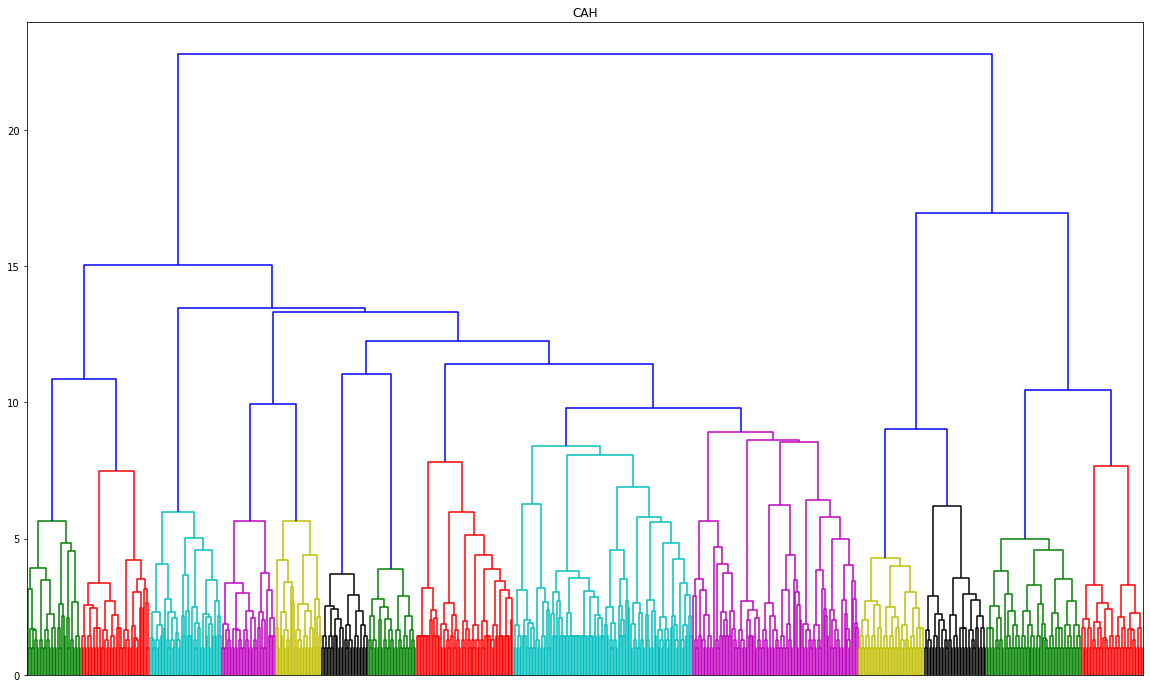

14 clusters


In [21]:
# hierarchical clustering

#générer la matrice des liens 
Z = linkage(clean_clust_1,method='ward',metric='euclidean') 

# génération et affichage du dendrogramme

plt.figure(figsize=(20,12))
plt.title("CAH") 

dendrogram(Z,labels=clean_clust_1.index,no_labels=True,color_threshold=9)

plt.show() 

groupes_cah = sch.fcluster(Z,t=9,criterion='distance') 
print(np.unique(groupes_cah).size, "clusters")

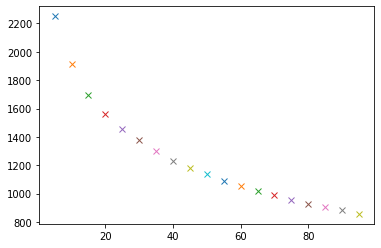

In [22]:
# find a good number of clusters (minimizing kmeans inertia with a reasonnable amount of clusters)

for i in range(2,100):
    if i%5==0:
        kmeans = cluster.KMeans(n_clusters=i) 
        kmeans.fit(clean_clust_1) 
        plt.plot(i,kmeans.inertia_,"x")
plt.show()

In [23]:
N_cluster=15 #according to the previous bend and the estimated amount of clusters
kmeans = cluster.KMeans(n_clusters=N_cluster) 
kmeans.fit(clean_clust_1)
labels=kmeans.labels_

In [24]:
# merge of clusters and artworks
test_clustering_1 = clustering_1[["Classification","Department","Medium"]].copy()
df_cluster = pd.DataFrame(labels, columns = ['cluster'])
test_clustering_1 = pd.concat([test_clustering_1,df_cluster], axis=1, sort=False)

artworks_cluster_1 = pd.merge(artworks,test_clustering_1,on=['Classification','Department','Medium'],how='outer')

artworks_cluster_1.head(3)


,Artwork_ID,Title,Artist_ID,Name,Date,Dimensions,Acquisition_Date,Credit,Catalogue,Department,...,Diameter,Circumference,Height,Length,Width,Depth,Weight,Duration,Medium,cluster
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,Architecture & Design,...,NaN,NaN,48.6,NaN,168.9,NaN,NaN,NaN,ink paper,3
1,34,"Royal Hunting Tent, project, Exterior perspective",7607,Marcel Kammerer,1900,"18 7/8 x 12 3/8"" (47.9 x 31.4 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,Architecture & Design,...,NaN,NaN,47.9,NaN,31.4,NaN,NaN,NaN,ink paper,3
2,36,"House in Krems, project, Krems, Austria, Eleva...",7608,Otto Schönthal,1905,"12 x 8 1/2"" (30.5 x 21.6 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,Architecture & Design,...,NaN,NaN,30.5,NaN,21.6,NaN,NaN,NaN,ink paper,3


As I said before, we can identify objects that belongs to the same "collection"(same departement, same mediums etc
), thanks to Object_Number.<br>It can give us an indication of the pertinence of the model.

In [25]:
# check if the objects with the same Object_Number are in the same clusters
test1=artworks_cluster_1.groupby(["cluster","Object_Number"]).size().reset_index().sort_values(by=0,ascending=False)
test2=artworks_cluster_1.groupby(["Object_Number"]).size().reset_index().sort_values(by=0,ascending=False)
test=pd.merge(test1,test2,on='Object_Number',how='outer')
test.head(20)

,cluster,Object_Number,0_x,0_y
0,4,11969,4929,4929
1,11,FC,1871,1983
2,2,FC,57,1983
3,4,FC,47,1983
4,8,FC,6,1983
5,0,FC,2,1983
6,8,,908,1045
7,14,,137,1045
8,4,4722015,669,669
9,3,FLWDR,648,648


In [26]:
# now with Artist_ID & Object_Number

test1=artworks_cluster_1.groupby(["cluster","Artist_ID","Object_Number"]).size().reset_index().sort_values(by=0,ascending=False)
test2=artworks_cluster_1.groupby(["Artist_ID","Object_Number"]).size().reset_index().sort_values(by=0,ascending=False)
test=pd.merge(test1,test2,on=['Artist_ID','Object_Number'],how='outer')
test.head(20)

,cluster,Artist_ID,Object_Number,0_x,0_y
0,4,229,11969,4929,4929
1,4,5145,4722015,669,669
2,3,6459,FLWDR,636,636
3,4,1533,2212014,399,399
4,3,101,651943,377,377
5,1,41829,722013,343,532
6,12,41829,722013,189,532
7,1,511,6771964,325,325
8,1,542,6801964,324,324
9,11,21398,FC,315,321


In [27]:
# Only with Artist_ID

test1=artworks_cluster_1.groupby(["cluster","Artist_ID"]).size().reset_index().sort_values(by=0,ascending=False)
test2=artworks_cluster_1.groupby(["Artist_ID"]).size().reset_index().sort_values(by=0,ascending=False)
test=pd.merge(test1,test2,on=['Artist_ID'],how='outer')
test.head(20)

,cluster,Artist_ID,0_x,0_y
0,4,229,5050,5050
1,1,710,2619,3318
2,12,710,616,3318
3,10,710,43,3318
4,2,710,27,3318
5,9,710,10,3318
6,7,710,2,3318
7,5,710,1,3318
8,3,7166,2551,2566
9,4,7166,15,2566


We can see that the clusters gather objects with the same object number and objects made by the same artists (in most cases, for the example above) : it shows that the features chosen to cluster the objects (Department, Classification, Medium) are pertinent, if we want to regroup artworks by type or technique used.


We can try to give a name to each cluster, or just check the type of artworks which are inside, by checking the words that appear the most among the clusters : (using WordCloud)

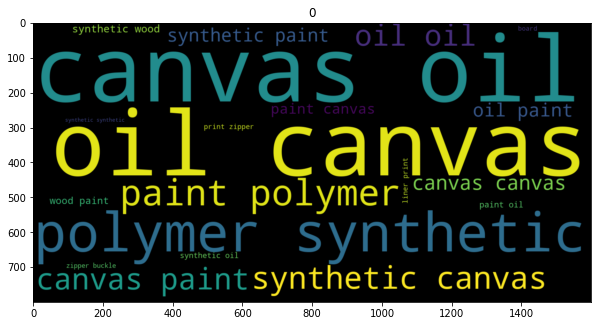

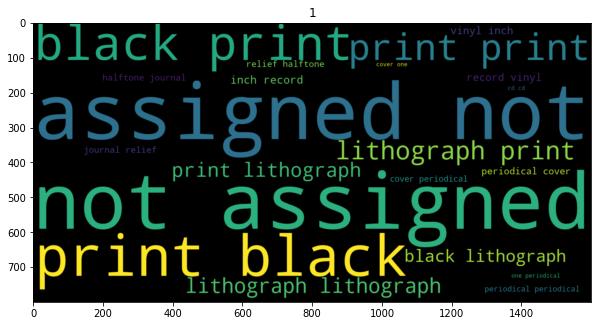

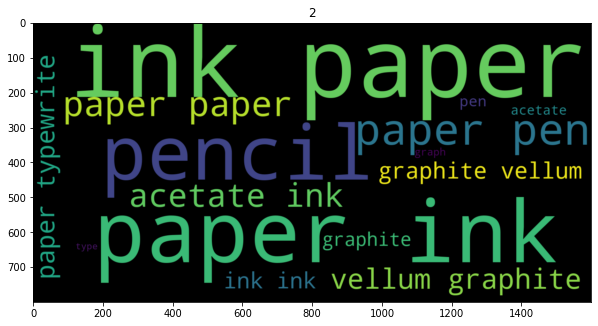

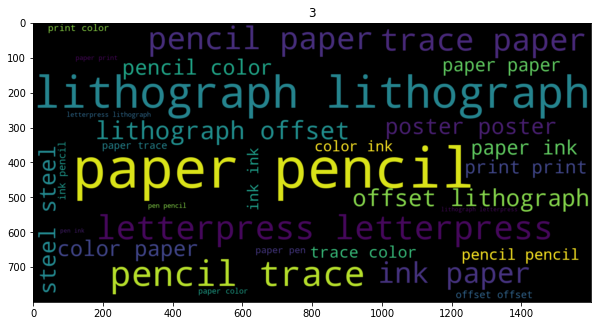

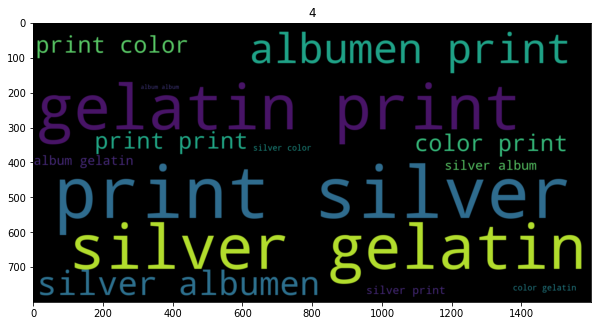

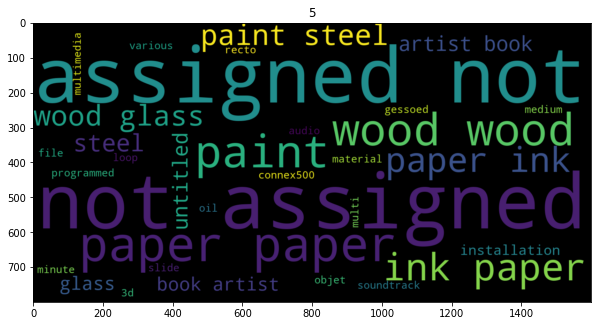

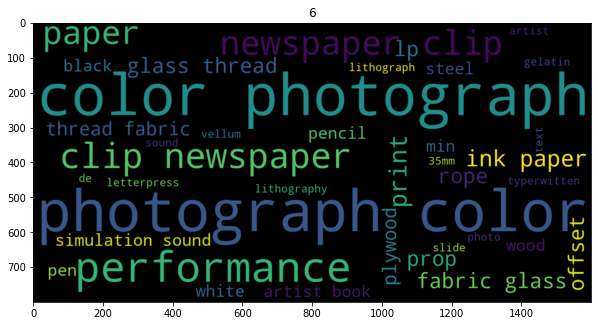

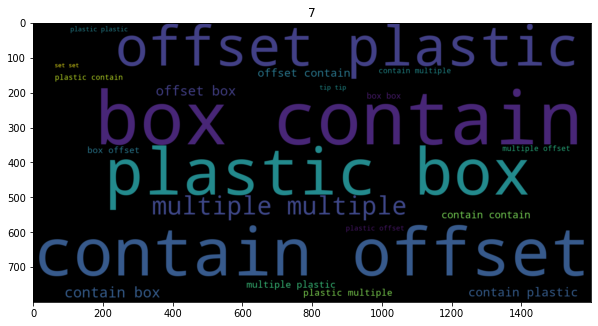

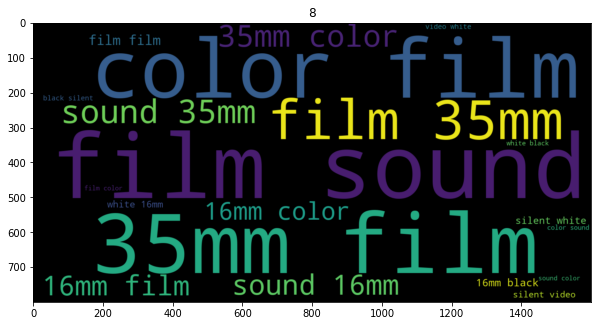

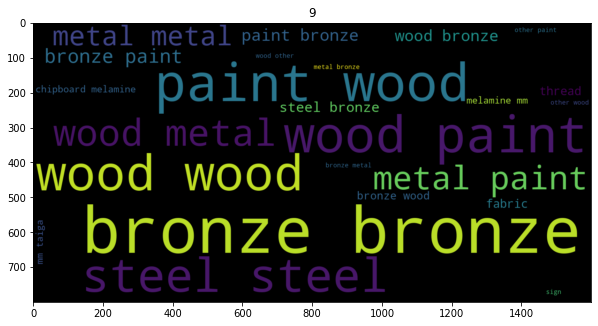

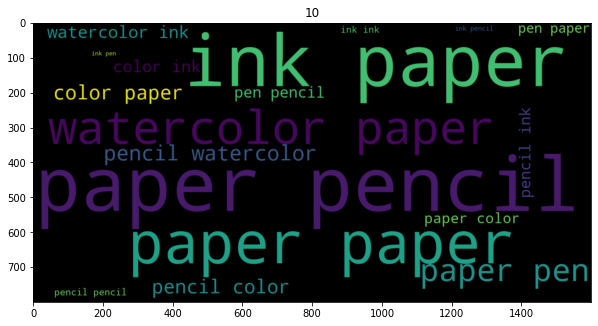

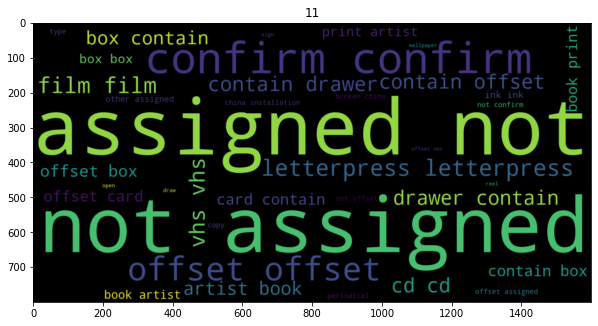

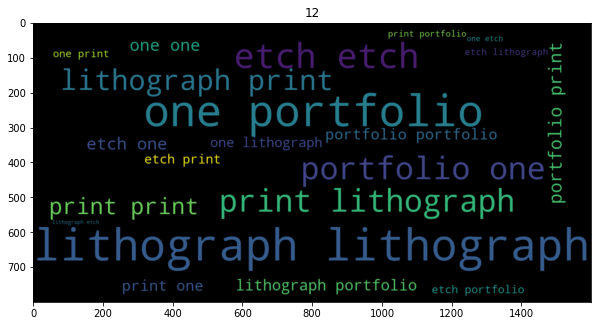

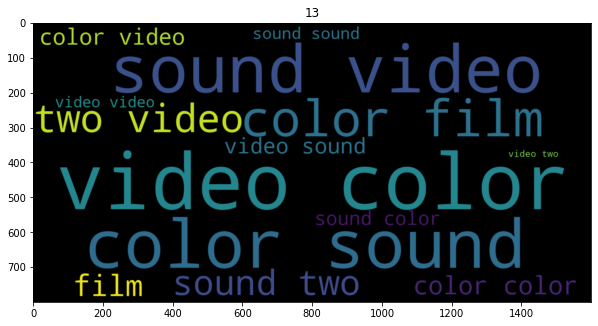

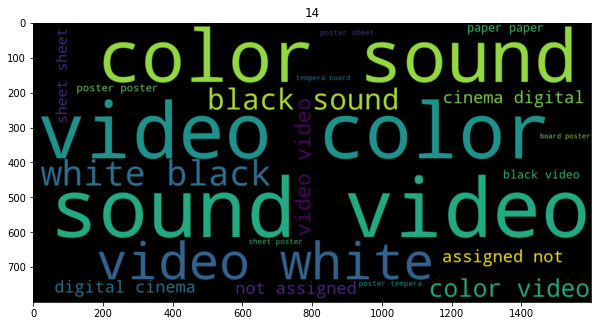

In [28]:
# Giving a name to each cluster ? -> medium
# a bit long to
cluster_medium=artworks_cluster_1.groupby(['cluster'])['Medium'].apply(lambda x: ' '.join(x)).reset_index()

for i in range(cluster_medium.shape[0]):
    plt.figure(figsize = (10,10))
    wc = WordCloud(min_font_size = 15,  max_words = 3000 , width = 1600 , height = 800).generate(cluster_medium.Medium[i])
    plt.imshow(wc,interpolation = 'bilinear')
    plt.title(cluster_medium.cluster[i])

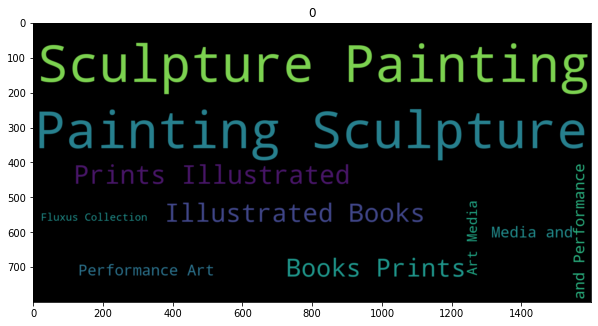

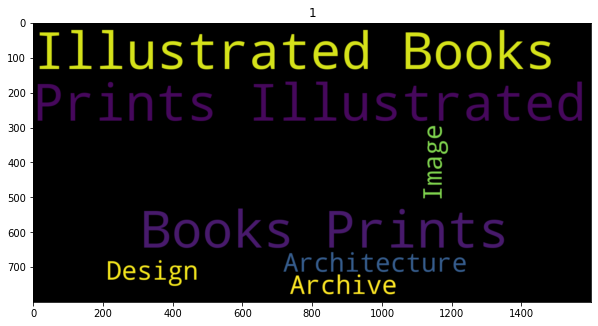

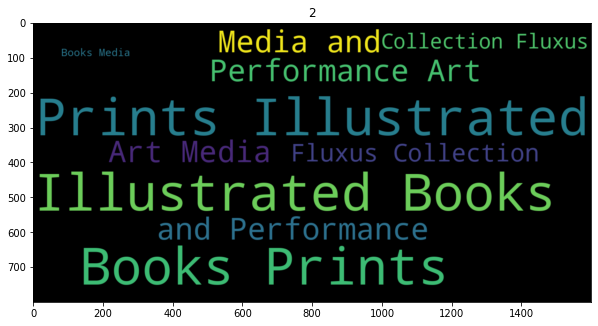

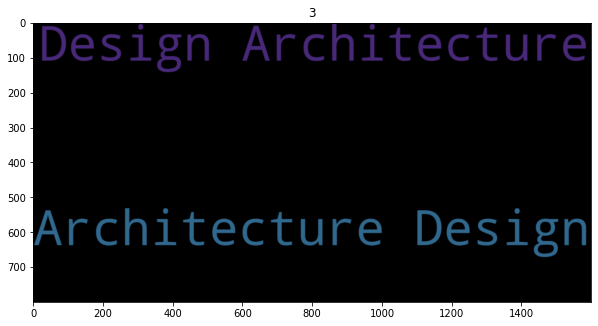

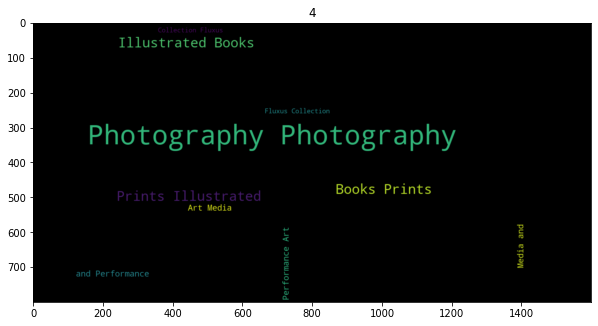

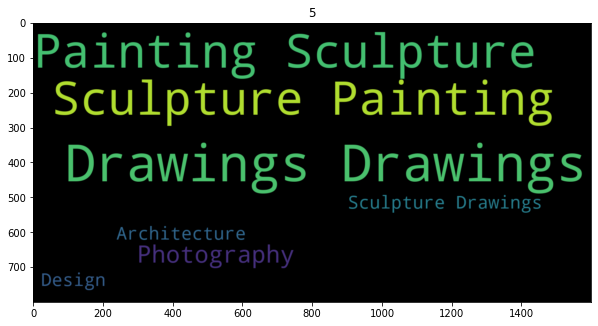

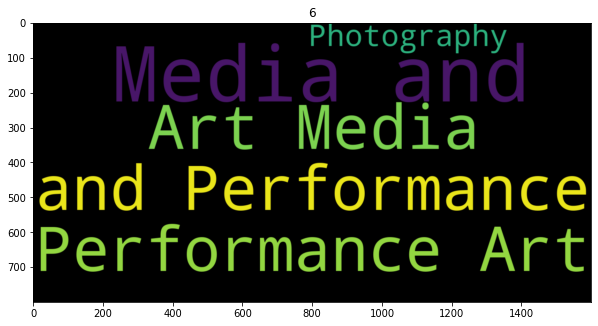

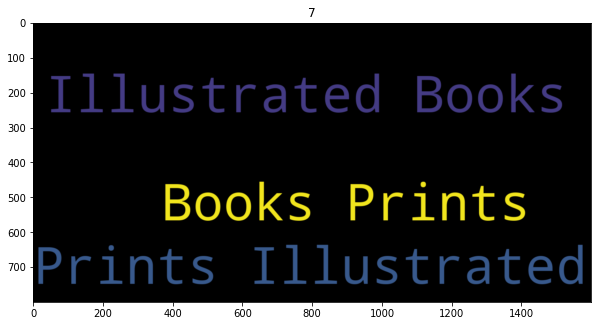

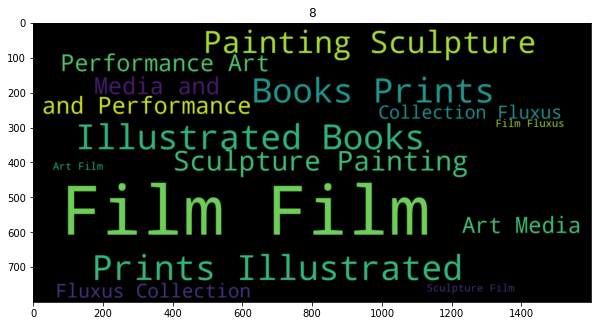

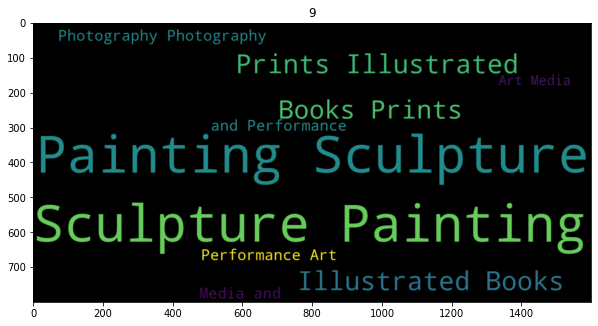

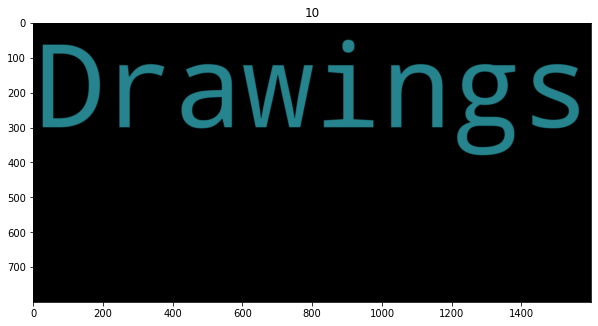

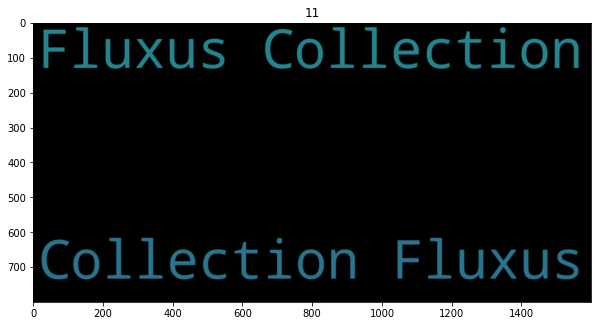

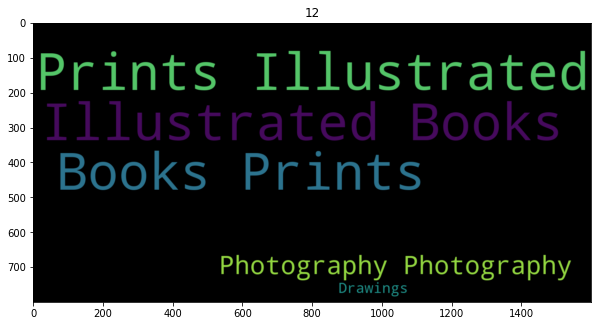

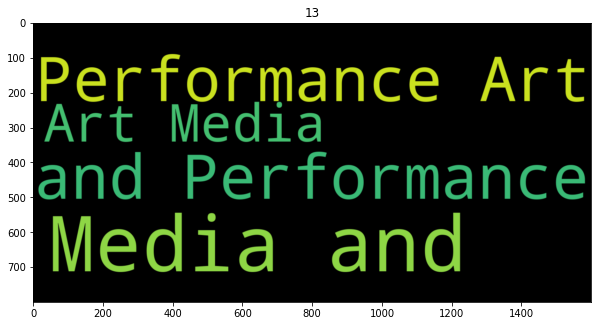

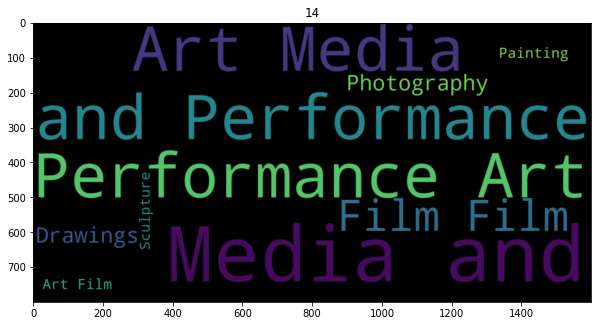

In [29]:
# Giving a name to each cluster ? -> department
cluster_department=artworks_cluster_1.groupby(['cluster'])['Department'].apply(lambda x: ' '.join(x)).reset_index()

for i in range(cluster_department.shape[0]):
    plt.figure(figsize = (10,10))
    wc = WordCloud(min_font_size = 15,  max_words = 3000 , width = 1600 , height = 800).generate(cluster_department.Department[i])
    plt.imshow(wc,interpolation = 'bilinear')
    plt.title(cluster_department.cluster[i])


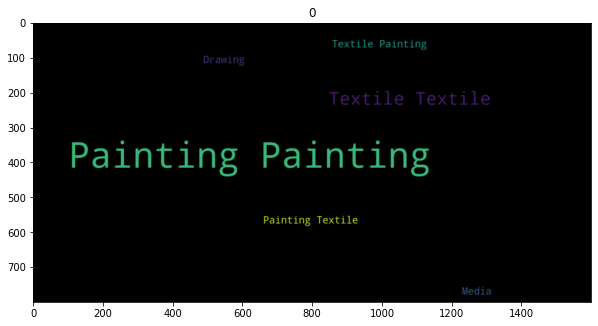

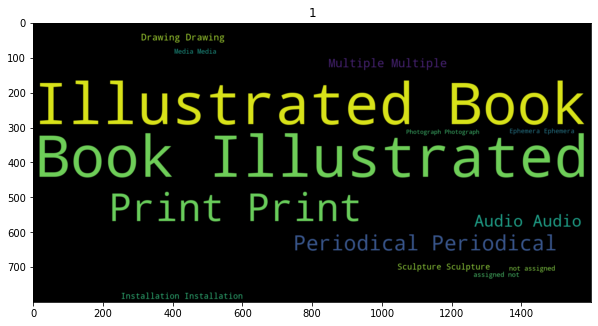

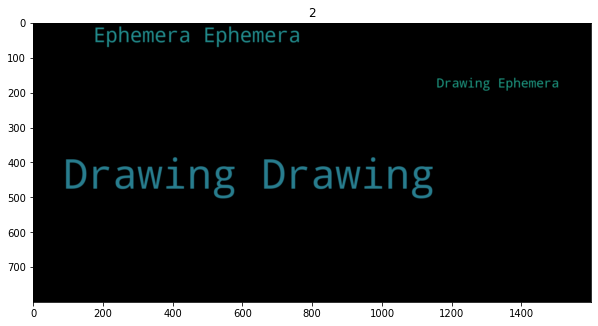

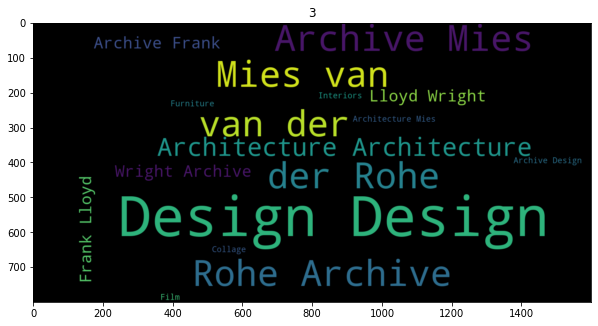

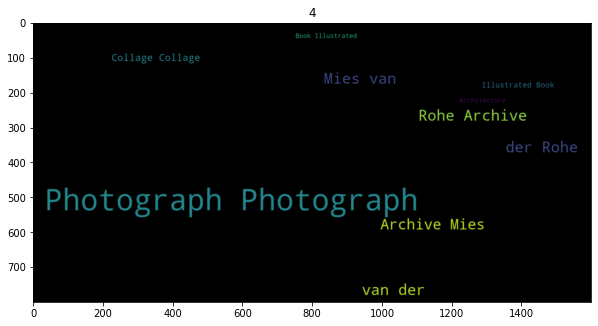

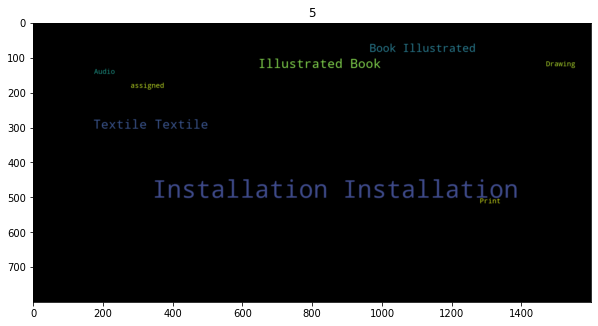

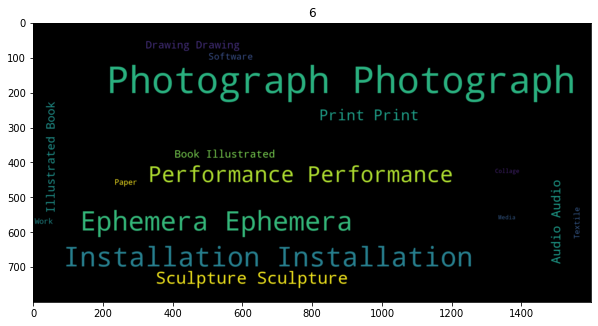

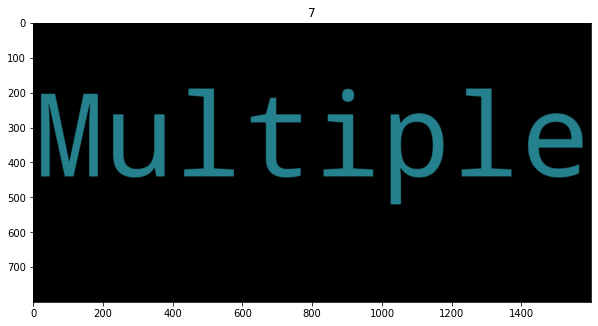

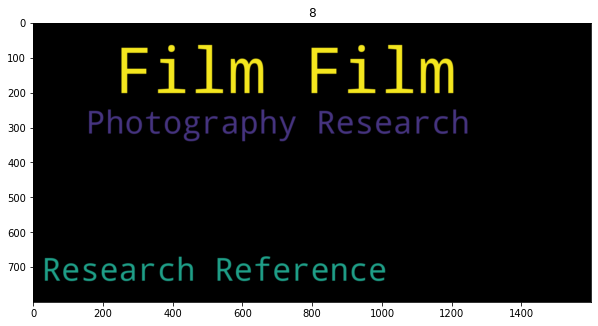

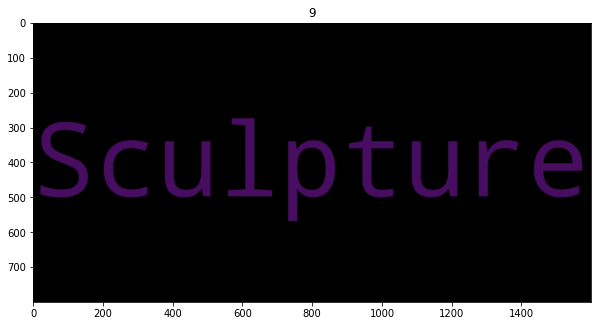

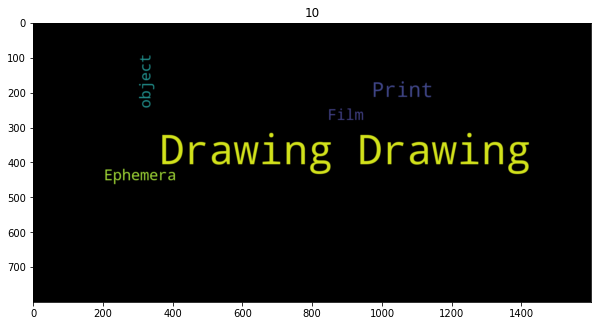

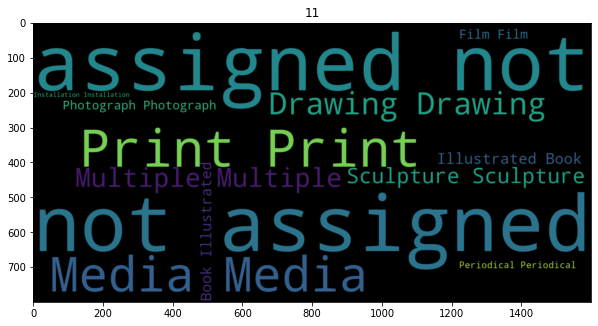

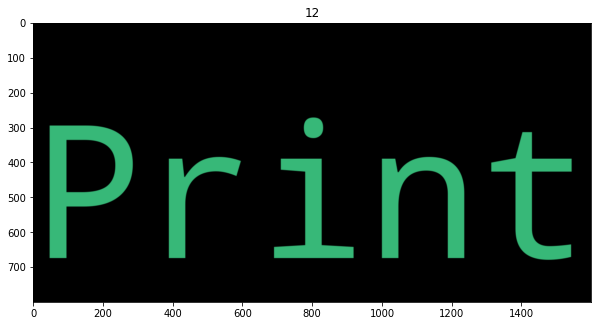

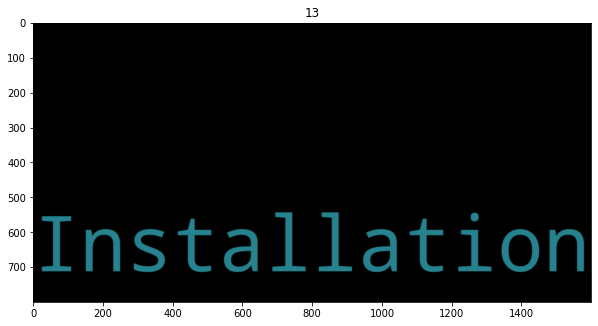

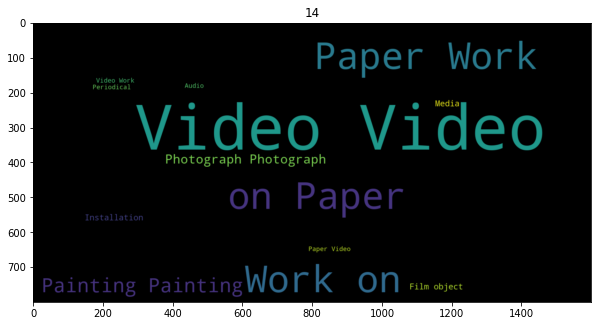

In [30]:
# Giving a name to each cluster ? -> classification
cluster_classification=artworks_cluster_1.groupby(['cluster'])['Classification'].apply(lambda x: ' '.join(x)).reset_index()

for i in range(cluster_classification.shape[0]):
    plt.figure(figsize = (10,10))
    wc = WordCloud(min_font_size = 15,  max_words = 3000 , width = 1600 , height = 800).generate(cluster_classification.Classification[i])
    plt.imshow(wc,interpolation = 'bilinear')
    plt.title(cluster_classification.cluster[i])


Finally, I could have chosen other ways (not based on artistic techniques) to cluster the objects, for example :
- using dimensional features (Diameter, Height ...) to regroup objects by size;
- using "Credit" column (by extracting information, as I did with "Medium".
